## Image processing
## Course work 2 (Part 2) - First way to do it
### María Cristina Velázquez Garcia
### María Fernanda Zavala López

### Instructions

Part 2 is very similar to part 1, in theory. This time, you will create your own 2 input color images. 

Be creative and have fun with it, you could use your camera phone, but you need to consider an 
ideal angle and light settings (right?). 

Next, create a gray-scale image mask (how will you do it?). Consider the characteristics of you input 
images.

Once everything is ready, blend the images in a seamless way. The color resulting image should 
show a smooth transition between the two images). 60 pts.

Find an example below

![](img5.png)

### Theory

The Gaussian smoothing operator is a 2-D convolution operator that is used to blur images and remove detail and noise. In this sense it is similar to the mean filter, but it uses a different kernel that represents the shape of a Gaussian (bell-shaped) hump. This kernel has some special properties which are detailed below.

**How it works**
The Gaussian distribution in 1-D has the form:
![](img7.jpg)

where sigma is the standard deviation of the distribution. We have also assumed that the distribution has a mean of zero (i.e. it is centered on the line x=0). 
![](img8.jpg)

In 2-D, an isotropic (i.e. circularly symmetric) Gaussian has the form:
![](img9.jpg)
![](img10.jpg)

**Images to use**

![](img6.png)

### Code

In [1]:
# Import libraries and utilities
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

This function helps to make the gaussian filter to smooth the image

In [2]:
def getkernel2(size=11, s=3.0):
    def gaussian_kernel(x, sigma=1.0):
        return np.exp(-x*2/(2*sigma*2))

    kernel = np.zeros((size, size), dtype=np.float32)
    centerx, centery = size // 2, size // 2
    for i in range(size):
        for j in range(size):
            dist_center = np.sqrt((i - centerx)**2 + (j - centery)**2)
            kernel[i, j] = dist_center

    kernel2 = gaussian_kernel(kernel, sigma=s)
    return kernel2

This function helps to create the correct mask for the eye to fit in the hand, in this case, the kernel takes the shape of a circle

In [3]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None: 
        center = (int(w/2), int(h/2))
        
    if radius is None: 
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

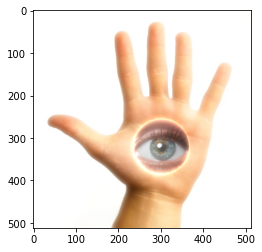

In [4]:
# Import image to use (eye)
A = cv.imread('ojo.png')
A = cv.cvtColor(A,cv.COLOR_BGR2RGB)

# Resize the image to make is squared
A = cv.resize(A,(512,512))

# Import image to use (hand)
B = cv.imread('mano.jpg')
B = cv.cvtColor(B,cv.COLOR_BGR2RGB)

# Resize the image to make is squared
B = cv.resize(B,(512,512))

# We create the mask in the shape to make it look like with the shape of the eye inside the hand 
mask = create_circular_mask(A.shape[0],A.shape[1],[512/1.7, 512/1.6], radius=65)
mask = np.stack([mask,mask,mask],axis=-1)

A = np.where(mask,A,0)
B = np.where(mask,0,B)

# generate Gaussian pyramid for A
levels = 3
G = A.copy()
gpA = [G]
for i in range(6):
    G = cv.pyrDown(G)
    gpA.append(G)
    
# generate Gaussian pyramid for B
G = B.copy()
gpB = [G]
for i in range(6):
    G = cv.pyrDown(G)
    gpB.append(G)
    
# generate Laplacian Pyramid for A
lpA = [gpA[levels]]
for i in range(levels,0,-1):
    GE = cv.pyrUp(gpA[i])
    L = cv.subtract(gpA[i-1],GE)
    lpA.append(L)
    
# generate Laplacian Pyramid for B
lpB = [gpB[levels]]
for i in range(levels,0,-1):
    GE = cv.pyrUp(gpB[i])
    L = cv.subtract(gpB[i-1],GE)
    lpB.append(L)
    
# Now add left and right halves of images in each level
LS = []
for la,lb in zip(lpA,lpB):
    rows,cols,dpt = la.shape          
    LS.append(la+lb)
    
# now reconstruct
ls_ = LS[0]
for i in range(1,levels+1):
    ls_ = cv.pyrUp(ls_)
    ls_ = cv.add(ls_, LS[i])

plt.imshow(ls_ )

The problem with this implementation (based on the Part 1 of the project) was that it was not able to apply the Gaussian filter mentioned before

## Image processing
## Course work 2 (Part 2) - Second way to do it

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.exposure as exposure
from skimage.draw import ellipse

#### Functions


In [6]:
def read_img(fname):
    img = cv2.imread(fname)
    img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2RGB)

    return img


def img2uint8(data):
    minV = np.min(data)
    maxV = np.max(data)

    data = (data-minV) / (maxV-minV)
    
    data = 255 * data 
    
    return data.astype(np.uint8)

def makeGaussianFilter(numRows, numCols, sigma, highPass=True):
    ctrY = int(numRows/2) + 1 if numRows % 2 == 1 else int(numRows/2)
    ctrX = int(numCols/2) + 1 if numCols % 2 == 1 else int(numCols/2)
    Y, X = np.mgrid[0:numRows, 0:numCols]
    imgFilter = np.exp(-1.0 * ((X - ctrX)**2 + (Y - ctrY)**2) / (2 * sigma**2))

    return 1 - imgFilter if highPass else imgFilter

def filterDFT(imageMatrix, filterMatrix):
    shiftedDFT = np.fft.fftshift(np.fft.fft2(imageMatrix))
    filteredDFT = shiftedDFT * filterMatrix

    return np.fft.ifft2(np.fft.ifftshift(filteredDFT))


def lowPass(imageMatrix, sigma):
    n,m = imageMatrix.shape
    
    return filterDFT(imageMatrix, makeGaussianFilter(n, m, sigma, highPass=False))


def highPass(imageMatrix, sigma):
    n,m = imageMatrix.shape
    
    return filterDFT(imageMatrix, makeGaussianFilter(n, m, sigma, highPass=True))


def stackGaussian(img, sigmas):
    gaussStack = []
    gaussStack.append(img.astype(float))
    for sigma in sigmas:
        imgLPF = lowPass(img, sigma)
        gaussStack.append(imgLPF.real)
    return np.array(gaussStack)


def stackLaplacian(img, sigmas):
    laplaceStack = []
    gaussStack = stackGaussian(img, sigmas)

    for i, sigma in enumerate(sigmas):
        imgHPF = gaussStack[i] - gaussStack[i+1]
        laplaceStack.append(imgHPF)

    laplaceStack.append(gaussStack[-1])
    return np.array(laplaceStack)


def img_blend(imgA, imgB, mask, wA, wB, sigmas):
    imgAL  = stackLaplacian(imgA, sigmas)
    imgBL  = stackLaplacian(imgB, sigmas)
    maskG  = stackGaussian(mask, sigmas)
    imgC = np.zeros((imgA.shape[0], imgA.shape[1]))
    N    = len(sigmas)+1
    for i in range(0, N):
        imgC += wA[i]*maskG[i]*imgAL[i] + wB[i]*(1-maskG[i])*imgBL[i]
    
    return imgC

In [7]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None: 
        center = (int(w/2), int(h/2))
        
    if radius is None: 
        radius = min(center[0], center[1], w-center[0], h-center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

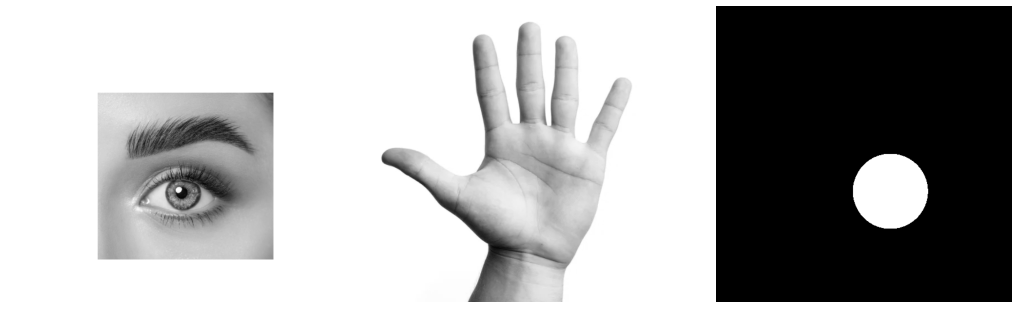

In [8]:
imgA = read_img('ojo.png')
imgA = cv2.cvtColor(src=imgA, code=cv2.COLOR_RGB2GRAY)
imgA = cv2.resize(imgA,(512,512))

imgB = read_img('mano.jpg')
imgB = cv2.cvtColor(src=imgB, code=cv2.COLOR_RGB2GRAY)
imgB = cv2.resize(imgB,(512,512))

mask     = create_circular_mask(512, 512, center = [512/1.7, 512/1.6], radius = 65)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
ax[0].imshow(imgA, interpolation='antialiased', cmap=plt.cm.gray)
ax[0].set_axis_off()
ax[1].imshow(imgB, interpolation='antialiased', cmap=plt.cm.gray)
ax[1].set_axis_off()
ax[2].imshow(mask, interpolation='antialiased', cmap=plt.cm.gray)
ax[2].set_axis_off()
plt.show()

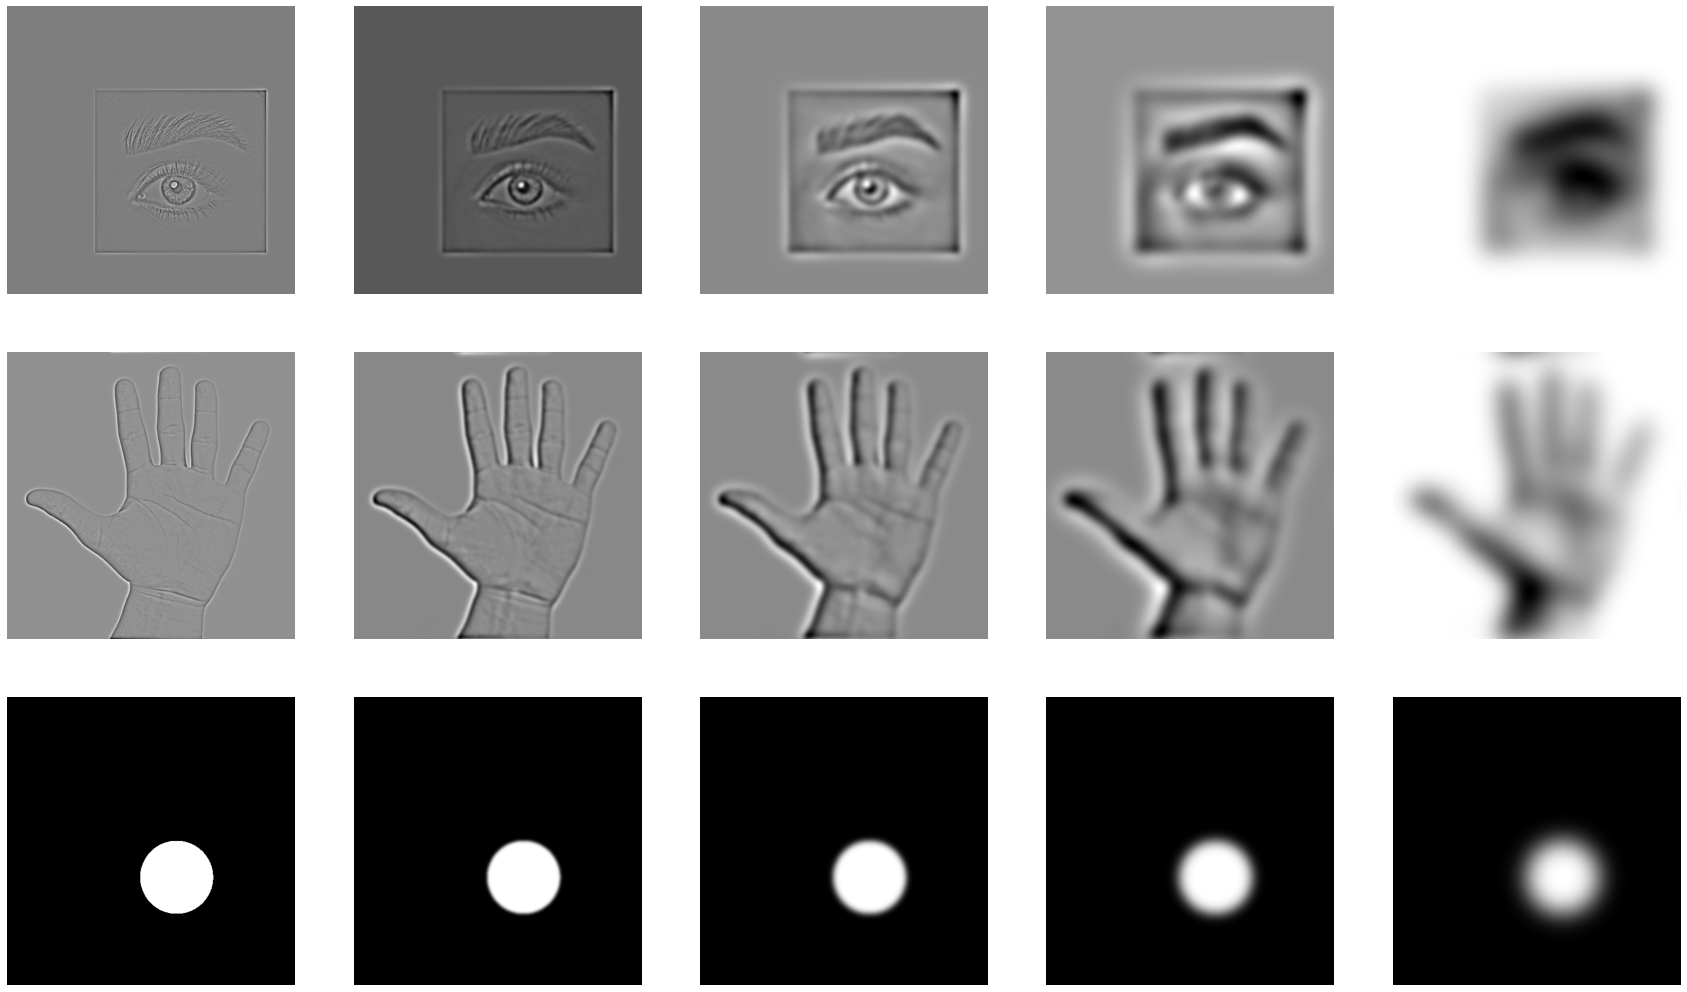

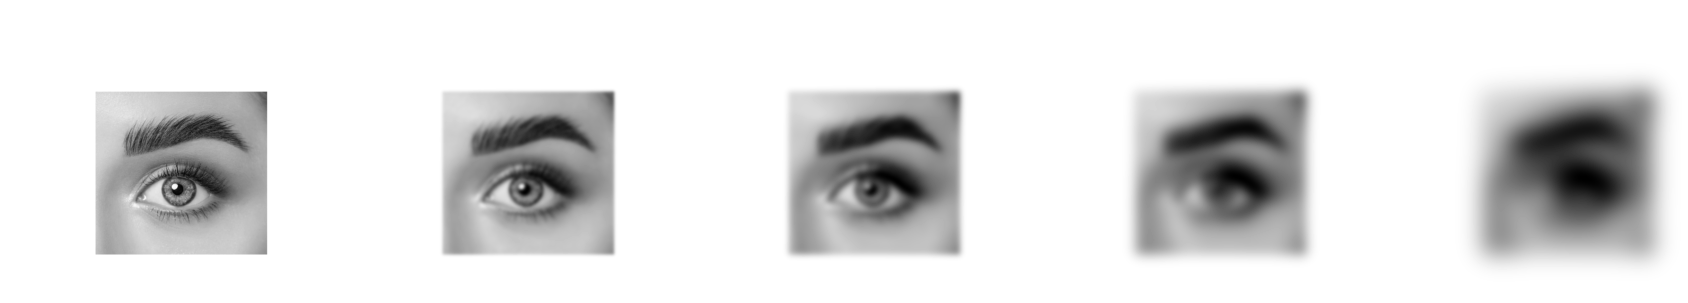

In [9]:
sigmas = [32, 16, 8, 4]
imgAL  = stackLaplacian(imgA, sigmas)
imgBL  = stackLaplacian(imgB, sigmas)
maskG  = stackGaussian(mask, sigmas)

N = len(sigmas)+1
fig, ax = plt.subplots(nrows=3, ncols=N, figsize=(N*6,18))
for i in range(0,N):
    ax[0,i].imshow(imgAL[i], interpolation='antialiased', cmap=plt.cm.gray)
    ax[0,i].set_axis_off()
    ax[1,i].imshow(imgBL[i], interpolation='antialiased',  cmap=plt.cm.gray)
    ax[1,i].set_axis_off()
    ax[2,i].imshow(maskG[i], interpolation='antialiased', cmap=plt.cm.gray)
    ax[2,i].set_axis_off()
plt.show()

imgAG = stackGaussian(imgA, sigmas)
N = len(sigmas)+1
fig, ax = plt.subplots(nrows=1, ncols=N, figsize=(N*6,18))
for i in range(0,N):
    ax[i].imshow(imgAG[i], interpolation='antialiased', cmap=plt.cm.gray)
    ax[i].set_axis_off()
plt.show()

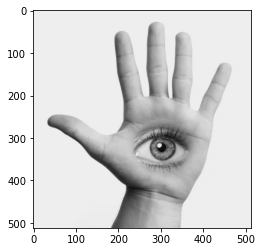

In [10]:
# image blending version
wA   = [0.5, 0.5, 0.5, 0.5, 0.5]
wB   = [0.5, 0.5, 0.5, 0.5, 0.5]

imgC = img_blend(imgA, imgB, mask, wA, wB, sigmas)

plt.imshow(imgC, cmap=plt.cm.gray )

The problem with this implementation is that we have not been able to make it work for RGB models, since some of the functions work only for two parameters (gray scale)